<a href="https://colab.research.google.com/github/maritverboom/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Group 15
Bart Formsma: 4438450

Eline van Lange: 4390210

Laurien Reinders: 4472306

Marit Verboom: 4453778


In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [2]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns

# Feature selection
from sklearn import feature_selection
# Univariate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import GenericUnivariateSelect

# Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import AlphaSelection
from yellowbrick.datasets import load_concrete
from sklearn.feature_selection import SelectFromModel

# Classifiers
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Statistics
from statistics import mean
from statistics import stdev
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  wa

## Data Loading
- Loading the provided Head & Neck dataset
- Splitting the data in train- and testset
- Binarizing tumor stages: TM12 = 0, TM34 = 1


In [3]:
#Import dataset
from hn.load_data import load_data
data = load_data()
data_start = data
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Splitting the data in train- and testpart with a portion of 'test_size' testing data (20%)
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

print(f'The number of rows of train data : {len(data_train.index)}')
print(f'The number of rows of test data : {len(data_test.index)}')

# dataframe containing tumor stadium of subject (T12/T34)
stage_train = data_train['label']             
stage_test = data_test['label'] 

# dataframe containing all feature columns except 'label' (tumor stadium of subject)
data_train = data_train.drop(columns='label') 
data_test = data_test.drop(columns='label')

# Binarize label data
stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
stage_train = [i[0] for i in stage_train]
stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
stage_test = [i[0] for i in stage_test]

labels_T12_train = stage_train.count(0)
labels_T12_test = stage_test.count(0)
labels_T34_train = stage_train.count(1)
labels_T34_test = stage_test.count(1)
print(f'Train samples with label T12: {labels_T12_train}/{len(data_train.index)}, Test samples with label T12: {labels_T12_test}/{len(data_test.index)}, total number of samples with label T12: {labels_T12_train + labels_T12_test}/{len(data.index)}')
print(f'Train samples with label T34: {labels_T34_train}/{len(data_train.index)}, Test samples with label T34: {labels_T34_test}/{len(data_test.index)}, total number of samples with label T34: {labels_T34_train + labels_T34_test}/{len(data.index)}')


The number of samples: 113
The number of columns: 160
The number of rows of train data : 90
The number of rows of test data : 23
[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]


## Data cleaning
- Removing columns where > 25% of the values are 0.0
- Removing columns whit a constant value


In [4]:
def data_cleaning(data_train, data_test):
    """
    Feature for cleaning the data.
    """
    # Remove all columns where more than 25% of the values are 0.0
    drop_cols_train = data_train.columns[(data_train == 0).sum() > 0.25*data_train.shape[1]]
    drop_cols_test = data_test.columns[(data_train ==0).sum() > 0.25*data_train.shape[1]]
    data_train.drop(drop_cols_train, axis = 1, inplace = True) 
    data_test.drop(drop_cols_test, axis = 1, inplace = True)
    
    # Remove all columns with no std
    drop_std_train = data_train.columns[data_train.std() == 0]
    drop_std_test = data_test.columns[data_train.std() == 0]
    data_train.drop(drop_std_train, axis = 1, inplace = True) 
    data_test.drop(drop_std_test, axis = 1, inplace = True)
    
    return data_train, data_test

data_train, data_test = data_cleaning(data_train, data_test)

print(f'TRAIN: The number of columns after preprocessing: {len(data_train.columns)}, and the number of rows: {len(data_train.index)}')
print(f'TEST: The number of columns after preprocessing: {len(data_test.columns)},  and the number of rows: {len(data_test.index)}')


TRAIN: The number of columns after preprocessing: 150, and the number of rows: 90
TEST: The number of columns after preprocessing: 150,  and the number of rows: 23


## Data Scaling

- Scaling the train- and test dataset with a Standard Scaler
 

In [0]:
def data_scaling(data_train, data_test):
    """
    Function to scale the data using a StandardScaler.
    """
    # Scale the data (train on train set)
    scaler = preprocessing.StandardScaler()   
    scaler.fit(data_train)  

    # Perform scaling on both train and testset, returing scaled dataframe
    data_train_scaled = pd.DataFrame(scaler.transform(data_train), columns = data_train.columns)
    data_test_scaled = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns) 

    return data_train_scaled, data_test_scaled

data_train_scaled, data_test_scaled = data_scaling(data_train, data_test)


## Data robust scaling

In [0]:
def data_scaling_robust(data_train, data_test):
    """
    Function to scale the data using a RobustScaler.
    """
    # Scale the data (train on train set)
    scaler = preprocessing.RobustScaler()   
    scaler.fit(data_train)  

    # Perform scaling on both train and testset, returing scaled dataframe
    data_train_scaled_robust = pd.DataFrame(scaler.transform(data_train), columns = data_train.columns)
    data_test_scaled_robust = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns) 

    return data_train_scaled, data_test_scaled

data_train_scaled, data_test_scaled = data_scaling(data_train, data_test)

## Preprocessing: Feature selection/extraction

- Recursive Feature Elimination
- Univariate Feature Selection
- Principal Component Analysis
- L1/Lasso Regression Feature Selection

## Recursive Feature Elimination

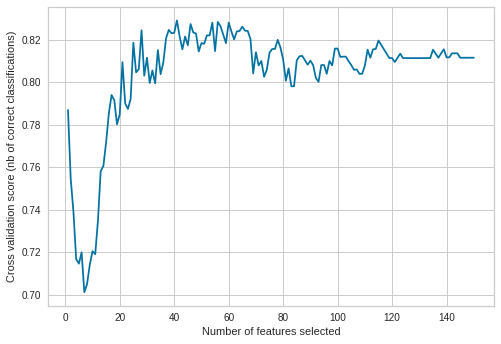

Num Features: 41
Selected Features: [False False False False False False False False  True False  True False
 False False False False False False  True  True  True False  True False
  True False  True False False False False False False False False False
 False False False False  True  True  True False False False False False
 False False False  True False False False False  True  True False False
  True False False False  True False False False False False False False
 False False False False False  True False False False False False False
 False False  True False False False False False False  True  True False
  True False  True False  True  True False False False False False False
  True  True  True False False False False  True  True False False False
  True  True  True  True False  True  True  True  True False  True  True
 False False False False False False False False  True False False False
  True False False False False False]
Feature Ranking: [  7  57  36  38  60  92  37  97 

In [0]:
# Create the RFE object
svc = svm.SVC(kernel="linear")  

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
fit_rfecv = rfecv.fit(data_train_scaled, stage_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Num Features: %d" % fit_rfecv.n_features_)
print("Selected Features: %s" % fit_rfecv.support_)
print("Feature Ranking: %s" % fit_rfecv.ranking_)

data_train_rfecv = rfecv.transform(data_train_scaled)
data_test_rfecv = rfecv.transform(data_test_scaled)

print(data_train_rfecv.shape)
print(data_test_rfecv.shape)

##  Feature selection using univariate feature selection

In [0]:
# Eventuele hyperparameters die nog kunnen worden aangepast: methodes voor univariate feature selection (selectKBest, SelectPercentile, en nog meer),
# measures om 'best' te bepalen chi2, f_classif, mutual_info_classif
# aantal features dat je selecteert, getal voor percentile, getal voor k-best, etc.
# Moeilijk om deze hyperparameters te tunen aangezien de performance pas wordt bepaald bij het toepassen van de classifier, zal waarschijnlijk ook verschillen per classifier.
# 
# Bij het opnieuw splitten van de data in een train en test set zie je dat er een andere set aan features geselecteerd wordt, zijn overeenkomsten maar je ziet ook verschillen. Zeer waarschijnlijk leidt dit uiteindelijk tot een hogere variantie in performance bij het nemen van een nieuwe split mbv cross validatie checken.

def uni_features(data_train, data_test, stage_train):
    """
    Function to perform univariate feature selection
    """
    # Apply SelectPercentile to train data to extract top 20% best features according to train data
    selector_uni = SelectPercentile(f_classif, percentile=20)
    selector_uni.fit(data_train, stage_train)
    data_train_uni = selector_uni.transform(data_train)
    data_test_uni = selector_uni.transform(data_test)

    return data_train_uni, data_test_uni


selector_uni = SelectPercentile(f_classif, percentile=20)
fit_uni = selector_uni.fit(data_train, stage_train)
data_train_uni = selector_uni.transform(data_train)
data_test_uni = selector_uni.transform(data_test)

# Visualisation of the selected best 20% features
dfscores = pd.DataFrame(fit_uni.scores_)
dfcolumns = pd.DataFrame(data_train.columns)

# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# Print dataframe
print(featureScores.nlargest(int(0.2*len(featureScores)),'Score'))  #print 40 best features



print(data_train_uni.shape)
print(data_test_uni.shape)

                                         Specs      Score
39                         tf_GLRLM_RunEntropy  46.050038
42                      tf_GLRLM_RunPercentage  35.595677
25                          sf_rad_dist_avg_2D  34.604728
40             tf_GLRLM_RunLengthNonUniformity  34.129891
41   tf_GLRLM_RunLengthNonUniformityNormalized  30.919687
32             tf_GLRLM_GrayLevelNonUniformity  27.716001
128                       tf_Gabor_0.5A2.36max  27.338882
1                                   hf_entropy  27.102321
125                      tf_Gabor_0.5A1.57skew  25.459758
131                      tf_Gabor_0.5A2.36skew  25.247027
134                     tf_LBP_kurtosis_R3_P12  24.617461
0                                    hf_energy  24.279270
130                       tf_Gabor_0.5A2.36min  23.833002
43                        tf_GLRLM_RunVariance  23.660150
121                      tf_Gabor_0.5A1.57kurt  22.248979
127                      tf_Gabor_0.5A2.36kurt  20.169067
46       tf_GL

## Principal Component Analysis (PCA)


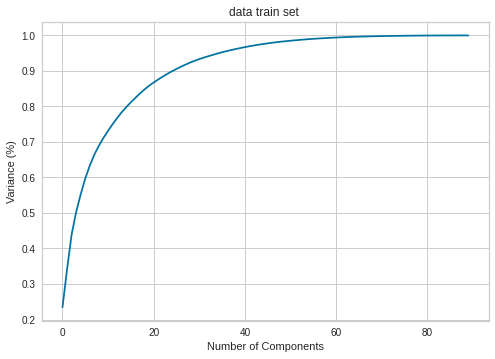

(90, 55)
(23, 55)


In [0]:

# Create a function for calculating PCA
def pca(data_train, data_test):
    """
    Function for PCA

        data_train = training data
        data_test = testing data

    Output is transformed train- and testdata
    """
    pca=PCA().fit(data_train)
    var = np.cumsum(pca.explained_variance_ratio_)
    n_comp = np.where(var>0.99)[0][0]

    pca_train = PCA(n_components=n_comp)
    pca_train.fit(data_train)

    # Transform data using PCA
    data_train_trans = pca_train.transform(data_train)
    data_test_trans = pca_train.transform(data_test)
    
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') # for each component
    plt.title('data train set ')
    plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

    # Return transformed train- and testdata
    return data_train_trans, data_test_trans

data_train_pca, data_test_pca = pca(data_train_scaled, data_test_scaled)
print(data_train_pca.shape)
print(data_test_pca.shape)



## Lasso feature selection


The optimal alpha = 0.049771980766083426
Selected 14 from 150 features.


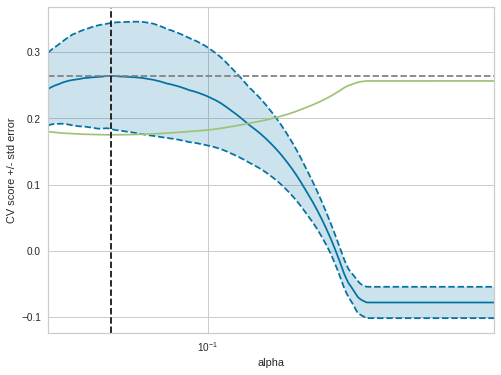

In [0]:
lasso = Lasso(max_iter=10000)
n_alphas = 200
alphas = np.logspace(-1.5, -0.1, n_alphas)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(data_train_scaled, stage_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(data_train_scaled, stage_train)
#visualizer.show()

alpha_best = model.alpha_
print(f'The optimal alpha = {alpha_best}')

#L1_selection = Lasso(alpha=alpha_best, max_iter=10000)
#L1_selection.fit(data_train_scaled, stage_train)
#train_score=L1_selection.score(data_train_scaled,stage_train)
#coeff_used = np.sum(L1_selection.coef_!=0)
#print("training score:", train_score) 
#print("number of features used: ", coeff_used)

def lasso():
    """
    Function to perform L1 feature selection
    """" 
    alphas = np.logspace(-1.5, -0.1, n_alphas)
    hyperparameters_l1 = [{'alpha': alphas}]
    n_folds = 5
    clf = GridSearchCV(lasso, hyperparameters_l1, cv=n_folds, refit=False)
    model_l1 = LassoCV(alphas = alphas)
    alpha_best = model.alpha_
    selector_l1 = SelectFromModel(estimator=Lasso(alpha=alpha_best, random_state = 42))
    selector_l1.fit(data_train, stage_train)
    data_train_l1 = selector.transform(data_train)
    data_test_l1 = selector.transform(data_test)
    return data_train_l1, data_test_l1

def uni(data_train, data_test, stage_train, percentile=20):
    """
    Function to perform univariate feature selection
    """
    # Apply SelectPercentile to train data to extract top best features according to train data
    selector_uni = SelectPercentile(f_classif, percentile)
    selector_uni.fit(data_train, stage_train)
    data_train_uni = selector_uni.transform(data_train)
    data_test_uni = selector_uni.transform(data_test)

    return data_train_uni, data_test_uni

selector = SelectFromModel(estimator=Lasso(alpha=alpha_best, random_state = 42))
selector.fit(data_train_scaled, stage_train)
n_original = data_train_scaled.shape[1]
data_train_l1 = selector.transform(data_train_scaled)
data_test_l1 = selector.transform(data_test_scaled)
n_selected = data_train_l1.shape[1]
print(f"Selected {n_selected} from {n_original} features.")



## kNN 

The train accuracy of a kNN x classifier with x feature selection: 0.8625
The validation accuracy of a kNN x classifier with x feature selection: 0.6666666666666666
The AUC of validation data: 0.6912382062382063
The sensitivity of validation data: 0.6333333333333333
The specificity of validation data: 0.7
The train accuracy of a kNN x classifier with x feature selection: 0.7819444444444444
The validation accuracy of a kNN x classifier with x feature selection: 0.6833333333333333
The AUC of validation data: 0.6981800144300144
The sensitivity of validation data: 0.6888888888888889
The specificity of validation data: 0.6777777777777778
The train accuracy of a kNN x classifier with x feature selection: 0.8569444444444445
The validation accuracy of a kNN x classifier with x feature selection: 0.6944444444444444
The AUC of validation data: 0.7098303085803086
The sensitivity of validation data: 0.6222222222222222
The specificity of validation data: 0.7666666666666666


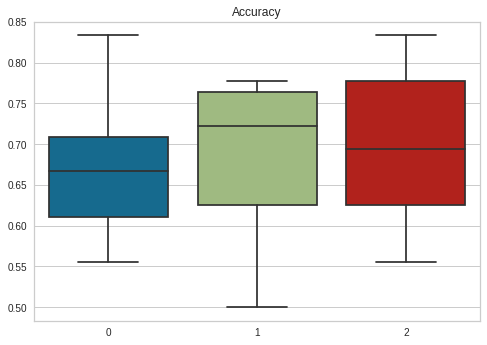

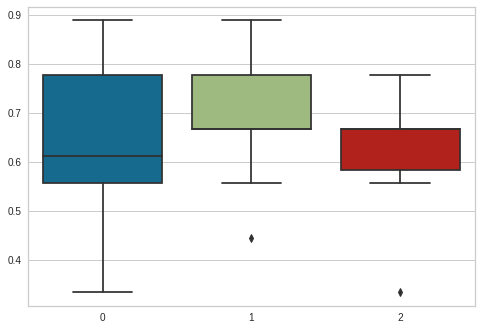

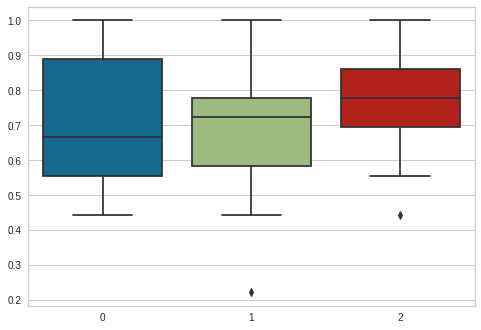

In [0]:
def knn_classifier(leaf_size, p, n_neigbors, weights, data_train, data_test, label_train, label_test):
  
    """
    Function for kNN training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    knn = neighbors.KNeighborsClassifier(n_neighbors = n_neigbors)
    knn.fit(data_train, label_train)
    label_train_knn = knn.predict(data_train)
    label_test_knn = knn.predict(data_test)
    score_train = knn.score(data_train, label_train)
    score_test = knn.score(data_test, label_test)
    return score_train, score_test, label_train_knn, label_test_knn

# Hyperparameters optimization 
leaf_size = list(range(1,50))
n_n = list(range(1,50))
p=[1,2]
weights = ['uniform', 'distance']

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_n, p=p, weights = weights)
knn_tune = neighbors.KNeighborsClassifier()
clf_tune_knn = model_selection.RandomizedSearchCV(knn_tune, hyperparameters, n_iter = 30, cv=5)

 # 10 keer opnieuw train-val   
sss = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

score_train_lasso = []
score_val_lasso = []
score_train_uni = []
score_val_uni = []
score_train_pca = []
score_val_pca = []

selectorlasso = SelectFromModel(estimator=Lasso(alpha=0.067, random_state = 42))
selectoruni = SelectPercentile(f_classif, percentile=20)
selectorpca = PCA(n_components = 20)
selectors = [selectorlasso, selectoruni, selectorpca]

score_train_box = []
score_val_box = []
sens_val_box = []
spec_val_box = []

for selector in selectors: 
    score_train_selector = []
    score_val_selector = []
    sens_val_selector = []
    spec_val_selector = []
    auc_val_selector = []
    for train_index, val_index in sss.split(data_train_scaled, stage_train):
        stage_train_k = np.array(stage_train)  

        split_X_train = data_train_scaled.loc[train_index]
        split_y_train = stage_train_k[train_index]
        split_X_val = data_train_scaled.loc[val_index]
        split_y_val = stage_train_k[val_index]

        selector.fit(split_X_train, split_y_train)
        split_X_train = selector.transform(split_X_train)
        split_X_val = selector.transform(split_X_val)

        best_model = clf_tune_knn.fit(split_X_train, split_y_train)
        leaf_size_best = best_model.best_estimator_.get_params()['leaf_size']
        p_best = best_model.best_estimator_.get_params()['p']
        n_n_best = best_model.best_estimator_.get_params()['n_neighbors']
        weights_best = best_model.best_estimator_.get_params()['weights']
   
        score_train, score_val, label_train, label_val = knn_classifier(leaf_size_best, 
                        p_best, n_n_best, weights_best, split_X_train, split_X_val, split_y_train, split_y_val)
        
        conf = confusion_matrix(split_y_val, label_val)
        sens_val = conf[0, 0]/(conf[0, 0]+conf[0, 1])
        spec_val = conf[1, 1]/(conf[1, 0]+conf[1, 1])
        
        auc_val=metrics.roc_auc_score(label_val, split_y_val)

        score_train_selector.append(score_train)
        score_val_selector.append(score_val)   
        sens_val_selector.append(sens_val)
        spec_val_selector.append(spec_val)
        auc_val_selector.append(auc_val)

        mean_train = mean(score_train_selector)
        mean_val = mean(score_val_selector)
        mean_sens = mean(sens_val_selector)
        mean_spec = mean(spec_val_selector)
        mean_auc=mean(auc_val_selector)
    
    score_train_box.append(score_train_selector)
    score_val_box.append(score_val_selector)
    sens_val_box.append(sens_val_selector)
    spec_val_box.append(spec_val_selector)

   
    print(f'The train accuracy of a kNN x classifier with x feature selection: {mean_train}')
    print(f'The validation accuracy of a kNN x classifier with x feature selection: {mean_val}')
    print(f'The AUC of validation data: {mean_auc}')
    print(f'The sensitivity of validation data: {mean_sens}')
    print(f'The specificity of validation data: {mean_spec}')

plt.figure(1)
sns.boxplot(data=score_val_box).set_title('Accuracy')

plt.figure(2)
sns.boxplot(data=sens_val_box)

plt.figure(3)
sns.boxplot(data=spec_val_box)


## SVM 

The train accuracy of a kNN x classifier with x feature selection: 0.8722222222222222
The validation accuracy of a kNN x classifier with x feature selection: 0.7333333333333333
The AUC of validation data: 0.7661111111111112
The sensitivity of validation data: 0.6888888888888889
The specificity of validation data: 0.7777777777777778
The train accuracy of a kNN x classifier with x feature selection: 0.9166666666666666
The validation accuracy of a kNN x classifier with x feature selection: 0.6444444444444445
The AUC of validation data: 0.6590601065601066
The sensitivity of validation data: 0.5777777777777777
The specificity of validation data: 0.711111111111111
The train accuracy of a kNN x classifier with x feature selection: 0.9333333333333333
The validation accuracy of a kNN x classifier with x feature selection: 0.6222222222222222
The AUC of validation data: 0.6427794427794429
The sensitivity of validation data: 0.5555555555555556
The specificity of validation data: 0.6888888888888889

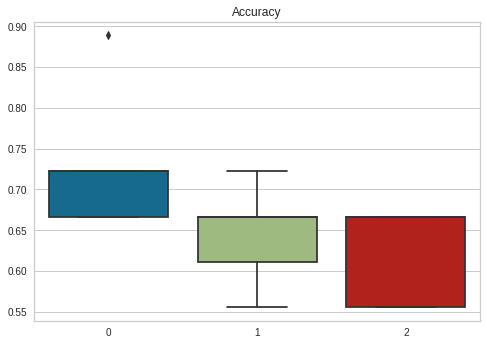

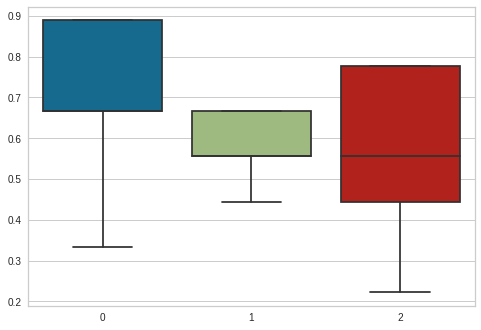

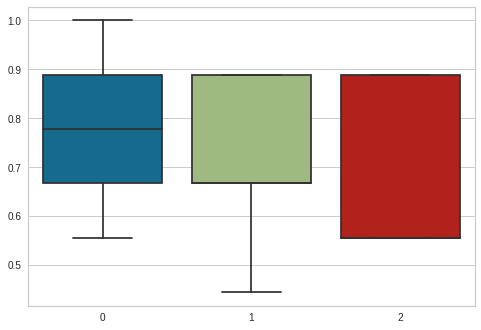

In [0]:
def svm_classifier(C, kernel, degree, gamma, data_train, data_test, label_train, label_test):
    """
    Function for SVM training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        svm_kernel = different kernels to be used (type = string)

    Output is two lists with the predicted class of the train- and testdata
    """
    svc = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
    svc.fit(data_train, label_train)

    # Predict the classes of the data 
    label_train_svm = svc.predict(data_train)
    label_test_svm= svc.predict(data_test)

    score_train = svc.score(data_train, label_train)
    score_test = svc.score(data_test, label_test)
    
    return score_train, score_test, label_train_svm, label_test_svm

#KERNELS 
kernels = ['linear', 'poly', 'rbf']
gammas = [0.1, 1, 10, 100]
cs = [0.1, 1, 10, 100, 1000]
degrees = [0, 1, 2, 3, 4, 5, 6] # use only for 'poly'

hyperparameters = dict(kernel = kernels, gamma = gammas, C = cs, degree = degrees)
svm_tune = svm.SVC()
clf_tune_svm = model_selection.RandomizedSearchCV(svm_tune, hyperparameters, n_iter = 30, cv=5)

# 10 keer opnieuw train-val   
sss = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

selectorlasso = SelectFromModel(estimator=Lasso(alpha=0.067, random_state = 42))
selectoruni = SelectPercentile(f_classif, percentile=20)
selectorpca = PCA(n_components = 20)
selectors = [selectorlasso, selectoruni, selectorpca]

score_train_box = []
score_val_box = []
sens_val_box = []
spec_val_box = []

#SVM met verschillende feature selection methods
for selector in selectors: 
    score_train_selector = []
    score_val_selector = [] 
    sens_val_selector = []
    spec_val_selector = []
    auc_val_selector = []
    for train_index, val_index in sss.split(data_train_scaled, stage_train):
        stage_train_k = np.array(stage_train)  

        split_X_train = data_train_scaled.loc[train_index]
        split_y_train = stage_train_k[train_index]
        split_X_val = data_train_scaled.loc[val_index]
        split_y_val = stage_train_k[val_index]
       
       # Fit Feature Selection
        selector.fit(split_X_train, split_y_train)
        split_X_train = selector.transform(split_X_train)
        split_X_val = selector.transform(split_X_val)

        best_model_svm = clf_tune_svm.fit(split_X_train, split_y_train)
        kernel_best = best_model_svm.best_estimator_.get_params()['kernel']
        gamma_best = best_model_svm.best_estimator_.get_params()['gamma']
        c_best = best_model_svm.best_estimator_.get_params()['C']
        degree_best = best_model_svm.best_estimator_.get_params()['degree']
    
        score_train, score_val, label_train, label_val = svm_classifier(c_best, 
                  kernel_best, degree_best, gamma_best, split_X_train, split_X_val, split_y_train, split_y_val)
    
        conf = confusion_matrix(split_y_val, label_val)
        sens_val = conf[0, 0]/(conf[0, 0]+conf[0, 1])
        spec_val = conf[1, 1]/(conf[1, 0]+conf[1, 1])
        auc_val=metrics.roc_auc_score(label_val, split_y_val)

        score_train_selector.append(score_train)
        score_val_selector.append(score_val)   
        sens_val_selector.append(sens_val)
        spec_val_selector.append(spec_val)
        auc_val_selector.append(auc_val)

        mean_train = mean(score_train_selector)
        mean_val = mean(score_val_selector)
        mean_sens = mean(sens_val_selector)
        mean_spec = mean(spec_val_selector)
        mean_auc=mean(auc_val_selector)
    
    score_train_box.append(score_train_selector)
    score_val_box.append(score_val_selector)
    sens_val_box.append(sens_val_selector)
    spec_val_box.append(spec_val_selector)

   
    print(f'The train accuracy of a kNN x classifier with x feature selection: {mean_train}')
    print(f'The validation accuracy of a kNN x classifier with x feature selection: {mean_val}')
    print(f'The AUC of validation data: {mean_auc}')
    print(f'The sensitivity of validation data: {mean_sens}')
    print(f'The specificity of validation data: {mean_spec}')

plt.figure(1)
sns.boxplot(data=score_val_box).set_title('Accuracy')

plt.figure(2)
sns.boxplot(data=sens_val_box)

plt.figure(3)
sns.boxplot(data=spec_val_box)



## Random Forest

In [0]:
def rfc_classifier(n_estimators, max_depth, min_samples_split, min_samples_leaf, 
                   bootstrap, class_weight, data_train, data_test, label_train, 
                   label_test):
    """
    Function for RFC training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create Random Forest Classifier and fit classifier on traindata
    rfc = RandomForestClassifier(n_estimators = n_estimators, max_depth = 
              max_depth, min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, bootstrap = bootstrap,
             class_weight = class_weight)
    rfc.fit(data_train, label_train)

    # Predict labels for train- and testdata
    label_train_rfc = rfc.predict(data_train)
    label_test_rfc = rfc.predict(data_test)
    
    score_train = rfc.score(data_train, label_train)
    score_test = rfc.score(data_test, label_test)

    return score_train, score_test, label_train_rfc, label_test_rfc

# Hyperparameters optimization
n_estimators = [10, 30, 50, 100, 300]     
max_depth = [5, 10, 15, 20, 30]                
min_samples_split = [2, 7, 10, 12, 20]      
min_samples_leaf = [1, 5, 10, 15, 20]             
bootstrap = [True, False]
class_weight = [{0: 1, 1: 0.001}, {0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 100}]


hyperparameters_rfc = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, bootstrap = bootstrap, 
             class_weight = class_weight)
rfc_tune = RandomForestClassifier()
clf_tune_rfc = model_selection.RandomizedSearchCV(rfc_tune, hyperparameters_rfc, n_iter = 30, cv=5)

# 10 keer opnieuw train-val   
sss = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

selectorlasso = SelectFromModel(estimator=Lasso(alpha=0.067, random_state = 42))
selectoruni = SelectPercentile(f_classif, percentile=20)
selectorpca = PCA(n_components = 20)
selectors = [selectorlasso, selectoruni, selectorpca]

score_train_box = []
score_val_box = []
sens_val_box = []
spec_val_box = []

# RF met feature selection methods
for selector in selectors: 
    score_train_selector = []
    score_val_selector = [] 
    sens_val_selector = []
    spec_val_selector = []
    auc_val_selector = []
    for train_index, val_index in sss.split(data_train_scaled, stage_train):
        stage_train_k = np.array(stage_train)  
        split_X_train = data_train_scaled.loc[train_index]
        split_y_train = stage_train_k[train_index]
        split_X_val = data_train_scaled.loc[val_index]
        split_y_val = stage_train_k[val_index]
       
       # Fit Feature Selection
        selector.fit(split_X_train, split_y_train)
        split_X_train = selector.transform(split_X_train)
        split_X_val = selector.transform(split_X_val)

        best_model_rfc = clf_tune_rfc.fit(split_X_train, split_y_train)

        n_estimators_best = best_model_rfc.best_estimator_.get_params()['n_estimators']
        max_depth_best = best_model_rfc.best_estimator_.get_params()['max_depth']
        min_samples_split_best = best_model_rfc.best_estimator_.get_params()['min_samples_split']
        min_samples_leaf_best = best_model_rfc.best_estimator_.get_params()['min_samples_leaf']
        bootstrap_best = best_model_rfc.best_estimator_.get_params()['bootstrap']
        class_weight_best = best_model_rfc.best_estimator_.get_params()['class_weight']

        score_train, score_val, label_train_, label_val = rfc_classifier(n_estimators_best, 
                        max_depth_best, min_samples_split_best, min_samples_leaf_best, 
                        bootstrap_best, class_weight_best, split_X_train, split_X_val, 
                        split_y_train, split_y_val)
    
        conf = confusion_matrix(split_y_val, label_val)
        sens_val = conf[0, 0]/(conf[0, 0]+conf[0, 1])
        spec_val = conf[1, 1]/(conf[1, 0]+conf[1, 1])
        
        auc_val=metrics.roc_auc_score(label_val, split_y_val)

        score_train_selector.append(score_train)
        score_val_selector.append(score_val)   
        sens_val_selector.append(sens_val)
        spec_val_selector.append(spec_val)
        auc_val_selector.append(auc_val)

        mean_train = mean(score_train_selector)
        mean_val = mean(score_val_selector)
        mean_sens = mean(sens_val_selector)
        mean_spec = mean(spec_val_selector)
        mean_auc=mean(auc_val_selector)
    
    score_train_box.append(score_train_selector)
    score_val_box.append(score_val_selector)
    sens_val_box.append(sens_val_selector)
    spec_val_box.append(spec_val_selector)

   
    print(f'The train accuracy of a kNN x classifier with x feature selection: {mean_train}')
    print(f'The validation accuracy of a kNN x classifier with x feature selection: {mean_val}')
    print(f'The AUC of validation data: {mean_auc}')
    print(f'The sensitivity of validation data: {mean_sens}')
    print(f'The specificity of validation data: {mean_spec}')

plt.figure(1)
sns.boxplot(data=score_val_box).set_title('Accuracy')

plt.figure(2)
sns.boxplot(data=sens_val_box)

plt.figure(3)
sns.boxplot(data=spec_val_box)


The train accuracy of a kNN x classifier with x feature selection: 0.8361111111111111
The validation accuracy of a kNN x classifier with x feature selection: 0.6777777777777778
The AUC of validation data: 0.6982267732267732
The sensitivity of validation data: 0.6222222222222222
The specificity of validation data: 0.7333333333333333


ValueError: ignored

## Neural network


*   Classifier obv neural network
*   Met cross validatie selectie van de juiste hyperparameters: hidden_layer_sizes, activation, solver, alpha, learning_rate, batch_size. Eventueel tunen op nog meer hyperparameters?
*   Getuned mbv randomized search


## stond nog erin, weet niet of het weg moet
neural_network = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

neural_network.fit(data_train_l1, stage_train)

score_train_neural_network = neural_network.score(data_train_l1, stage_train)

score_test_neural_network = neural_network.score(data_test_l1, stage_test)



In [0]:
def neural_network_classifier(hidden_layer_sizes, activation, solver, alpha, learning_rate, 
                              batch_size, data_train, data_test, label_train, label_test):
    """
    Function for neural network training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create neural network Classifier and fit classifier on traindata
    neural_network = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = 
              activation, solver = solver, 
             alpha = alpha, learning_rate = learning_rate,
             batch_size = batch_size)
    neural_network.fit(data_train, label_train)

    # Scores and predicted labels of neural network classifier
    label_train_neural_network = neural_network.predict(data_train)
    label_test_neural_network = neural_network.predict(data_test)
    
    score_train_neural_network = neural_network.score(data_train, label_train)
    score_test_neural_network = neural_network.score(data_test, label_test)

    return score_train_neural_network, score_test_neural_network, label_train_neural_network, label_test_neural_network

# Hyperparameters optimization

hyperparameters_neural_network = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                                  'activation': ['tanh', 'relu','identity', 'logistic'], 
                                  'solver': ['lbfgs', 'sgd', 'adam'],
                                  'alpha':[0.0001, 0.005, 0.05],
                                  'learning_rate':['constant', 'adaptive'],
                                  'batch_size':[5, 10, 15, 20, 25]}
neural_network_tune = MLPClassifier()
clf_tune_neural_network = model_selection.RandomizedSearchCV(neural_network_tune, 
                                      hyperparameters_neural_network, n_iter = 30, cv=5)

# For loop for calculation
score_train_nn = []
score_test_nn = []
stage_train_nn = []
stage_test_nn = []

for df, df_test in zip(data_train_fs, data_test_fs):
    best_model_neural_network = clf_tune_neural_network.fit(df, stage_train)

    hidden_layer_sizes_best = best_model_neural_network.best_estimator_.get_params()['hidden_layer_sizes']
    activation_best = best_model_neural_network.best_estimator_.get_params()['activation']
    solver_best = best_model_neural_network.best_estimator_.get_params()['solver']
    alpha_best = best_model_neural_network.best_estimator_.get_params()['alpha']
    learning_rate_best = best_model_neural_network.best_estimator_.get_params()['learning_rate']
    batch_size_best = best_model_neural_network.best_estimator_.get_params()['batch_size']
    
    score_train_n, score_test_n, stage_train_n, stage_test_n = neural_network_classifier(
                     hidden_layer_sizes_best, activation_best, solver_best, alpha_best, 
                     learning_rate_best, batch_size_best, df, df_test, 
                     stage_train, stage_test)

    score_train_nn.append(score_train_n)
    score_test_nn.append(score_test_n)
    stage_train_nn.append(stage_train_n)
    stage_test_nn.append(stage_test_n)


# Printing accuracy and predicted stage
print(f'Accuracy of neural network classifier on traindata: {score_train_nn}') # accuracy
print(f'Accuracy of neural network classifier on testdata: {score_test_nn}') # accuracy
print(stage_train_nn)
print(' ')
print(stage_test_nn)

## Putting it all together
- First: splitting start_data (hn dataframe) into a dataframe with features and one with stages

- Defining some functions we will later use
- Some functions were already defined in the exploration fase


In [0]:
stage = data_start['label']
data = data_start.drop(columns='label')
stage = preprocessing.label_binarize(stage, ['T12', 'T34'] )
stage = [i[0] for i in stage]

pd.options.mode.chained_assignment = None  

# PCA function

In [0]:
def pca_opt(data_train, data_test):
    """
    Function for PCA

        data_train = training data
        data_test = testing data

    Output is transformed train- and testdata
    """
    pca=PCA().fit(data_train)

    # Amount of n-components based on a variance level of 0.99
    var = np.cumsum(pca.explained_variance_ratio_)
    n_comp = np.where(var>0.99)[0][0]

    pca_train = PCA(n_components=n_comp)
    pca_train.fit(data_train)

    # Transform data using PCA
    data_train = pca_train.transform(data_train)
    data_test = pca_train.transform(data_test)

    # Return transformed train- and testdata
    return data_train, data_test

## Univariate feature selection function

In [0]:
# Eventuele hyperparameters die nog kunnen worden aangepast: methodes voor univariate feature selection (selectKBest, SelectPercentile, en nog meer),
# measures om 'best' te bepalen chi2, f_classif, mutual_info_classif
# aantal features dat je selecteert, getal voor percentile, getal voor k-best, etc.
# Moeilijk om deze hyperparameters te tunen aangezien de performance pas wordt bepaald bij het toepassen van de classifier, zal waarschijnlijk ook verschillen per classifier.
# 
# Bij het opnieuw splitten van de data in een train en test set zie je dat er een andere set aan features geselecteerd wordt, zijn overeenkomsten maar je ziet ook verschillen. Zeer waarschijnlijk leidt dit uiteindelijk tot een hogere variantie in performance bij het nemen van een nieuwe split mbv cross validatie checken.

def uni(data_train, data_test, stage_train, percentile=20):
    """
    Function to perform univariate feature selection
    """
    # Apply SelectPercentile to train data to extract top best features according to train data
    selector_uni = SelectPercentile(f_classif, percentile)
    selector_uni.fit(data_train, stage_train)
    data_train_uni = selector_uni.transform(data_train)
    data_test_uni = selector_uni.transform(data_test)

    return data_train_uni, data_test_uni

## Function to execute the correct feature selection method on train and test data

In [0]:
def execute_selector(train, test, stage_train, selector):
    """
    Function which decides which selector to apply to the outer data and test set
    Input:
    - Train: the train data on which the selector should be applied
    - Test: the test data on which the selector should be applied
    - Stage_train: the labels of the train data
    - Selector: the name of selector used according to the [selector_train] array
    Output: 
    - Selector_used: the type of selector that is performed on the data
    - Train_out: the train data transformed by the selector
    - Test_out: the test data transformed by the selector
    """
    if selector == 'inner_train_uni':
        selector_train_out, selector_test_out = uni(train, test, stage_train, 60)
        selector_used = 'Univariate'
    elif selector == 'inner_train_pca':
        selector_train_out, selector_test_out = pca_opt(train, test)
        selector_used = 'PCA'
    elif selector == 'inner_train_uni_pca':
        selector_train_out_uni, selector_test_out_uni = uni(train, test, stage_train, 60)
        selector_train_out, selector_test_out = pca_opt(selector_train_out_uni, selector_test_out_uni)
        selector_used = 'Combination univariate and PCA'
    else:
        print('no selector method was found according to given selector')
        selector_used = 'None'
    return selector_used, selector_train_out, selector_test_out

## Function to execute the correct feature selection method on train and test data - 2

In [0]:
def best_selector(train, test, stage_train, selector):
    """
    Function which decides which selector to apply to the outer data and test set
    Input:
    - Train: the train data on which the selector should be applied
    - Test: the test data on which the selector should be applied
    - Stage_train: the labels of the train data
    - Selector: the name of selector used according to the variable selector_used
    Output: 
    - Train_out: the train data transformed by the selector
    - Test_out: the test data transformed by the selector
    """
    if selector_used == 'Univariate':
        selector_train_out, selector_test_out = uni(train, test, stage_train, 60)
    elif selector_used == 'PCA':
        selector_train_out, selector_test_out = pca_opt(train, test)
    elif selector == 'Univariate and PCA':
        selector_train_out_uni, selector_test_out_uni = uni(train, test, stage_train, 60)
        selector_train_out, selector_test_out = pca_opt(selector_train_out_uni, selector_test_out_uni)
    else:
        print('no selector method was found according to given selector')
    return selector_train_out, selector_test_out

## kNN Optimization function

In [0]:
def knn_class(data_train, data_test, stage_train, stage_test):
    """
    Function for optimalizing the hyperparameters:
      - n_neighbours
      - weights
    in a kNN classifier.
    Output is:
      - knn: a classifier with optimized hyperparameters
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
    """
    
    # Hyperparameters optimization 
    n_n = list(range(1,30))
    # weights = ['uniform', 'distance']
    leaf_size = list(range(1,50))
    # p=[1,2]
    
    # hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_n, p=p, weights = weights)

    hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_n)
    knn_tune = neighbors.KNeighborsClassifier()
    clf_tune_knn = model_selection.RandomizedSearchCV(knn_tune, hyperparameters, n_iter = 30, cv=5)

    best_model = clf_tune_knn.fit(data_train, stage_train)
    n_n_best = best_model.best_estimator_.get_params()['n_neighbors']
    # weights_best = best_model.best_estimator_.get_params()['weights']
    leaf_size_best = best_model.best_estimator_.get_params()['leaf_size']
    # p_best = best_model.best_estimator_.get_params()['p']

    knn = neighbors.KNeighborsClassifier(leaf_size=leaf_size_best, n_neighbors=n_n_best)
    knn.fit(data_train, stage_train)
    label_train_knn = knn.predict(data_train)
    label_test_knn = knn.predict(data_test)
    
    # Performance
    acc_train = knn.score(data_train, stage_train)
    acc_test = knn.score(data_test, stage_test)
    # Calculating confusion matrix
    cm = metrics.confusion_matrix(stage_test, label_test_knn)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    sens = (TP / float(TP+FN))
    spec = (TN / float(TN + FP))

    try:
        auc_test = metrics.roc_auc_score(label_test_knn, stage_test)
    except ValueError:
        auc_test = float("NaN")
        
    return knn, acc_train, acc_test, auc_test, sens, spec

## SVM Optimization Function

In [0]:
def svm_class(data_train, data_test, stage_train, stage_test):
    """
    Function for optimalizing the hyperparameters:
      - kernel
      - gamma
      - C
      - degree
    in a SVM classifier.
    Output is:
      - svc: a classifier with optimized hyperparameters
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
     """
    # Hyperparameter optimization
    kernels = ['linear', 'poly', 'rbf']
    # gammas = [0.1, 1, 10, 100]
    cs = [0.1, 1, 10, 100, 1000]
    degrees = [0, 1, 2, 3, 4, 5, 6] # use only for 'poly'

    hyperparameters = dict(kernel = kernels, C = cs, degree = degrees)
    svm_tune = svm.SVC()
    clf_tune_svm = model_selection.RandomizedSearchCV(svm_tune, hyperparameters, n_iter = 30, cv = 5)

    best_model_svm = clf_tune_svm.fit(data_train,stage_train)
    kernel_best = best_model_svm.best_estimator_.get_params()['kernel']
    # gamma_best  = best_model_svm.best_estimator_.get_params()['gamma']
    C_best = best_model_svm.best_estimator_.get_params()['C']
    degree_best = best_model_svm.best_estimator_.get_params()['degree']

    svc = svm.SVC(C=C_best, kernel=kernel_best, degree=degree_best)
    svc.fit(data_train, stage_train)

    # Predict the classes of the data 
    label_train_svm = svc.predict(data_train)
    label_test_svm= svc.predict(data_test)
    
    # Performance
    acc_train = svc.score(data_train, stage_train)
    acc_test = svc.score(data_test, stage_test)
    # Calculating confusion matrix
    cm = metrics.confusion_matrix(stage_test, label_test_svm)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    sens = (TP / float(TP+FN))
    spec = (TN / float(TN + FP))

    try:
        auc_test = metrics.roc_auc_score(label_test_svm, stage_test)
    except ValueError:
        auc_test = float("NaN")
    
    return svc, acc_train, acc_test,  auc_test, sens, spec

## RF Optimization Function

In [0]:
def rf_class(data_train, data_test, stage_train, stage_test):
    """
    Function for optimalizing the hyperparameters:
      - n_neighbours
      - weights
    in a Random Forest classifier.
    Output is:
      - rfc: a classifier with optimized hyperparameters
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
    """

    # Hyperparameters optimization 
    n_estimators = [10, 30, 50, 100, 300]                  
    min_samples_split = [2, 7, 10, 12, 20]      
    min_samples_leaf = [3, 5, 10, 15, 20]             

    hyperparameters_rfc = dict(n_estimators=n_estimators, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)
    rfc_tune = RandomForestClassifier()
    clf_tune_rfc = model_selection.RandomizedSearchCV(rfc_tune, hyperparameters_rfc, n_iter = 30, cv=5)

    best_model = clf_tune_rfc.fit(data_train, stage_train)
    n_estimators_best = best_model.best_estimator_.get_params()['n_estimators']
    min_samples_split_best = best_model.best_estimator_.get_params()['min_samples_split']
    min_samples_leaf_best = best_model.best_estimator_.get_params()['min_samples_leaf']

    rfc = RandomForestClassifier(n_estimators=n_estimators_best, min_samples_split = min_samples_split_best, min_samples_leaf = min_samples_leaf_best)
    rfc.fit(data_train, stage_train)
    label_train_rfc = rfc.predict(data_train)
    label_test_rfc = rfc.predict(data_test)
    
    # Performance
    acc_train = rfc.score(data_train, stage_train)
    acc_test = rfc.score(data_test, stage_test)
    # Calculating confusion matrix
    cm = metrics.confusion_matrix(stage_test, label_test_rfc)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    sens = (TP / float(TP+FN))
    spec = (TN / float(TN + FP))

    try:
        auc_test = metrics.roc_auc_score(label_test_rfc, stage_test)
    except ValueError:
        auc_test = float("NaN")
        
    return rfc, acc_train, acc_test, auc_test, sens, spec

## Neural network Optimization Function

In [0]:
def nn_class(data_train, data_test, stage_train, stage_test):
    """
    Function for optimalizing the hyperparameters:
      - hidden_layer_sizes
      - batch_size
      - activation
    in a neural network classifier.
    Output is:
      - nn: a classifier with optimized hyperparameters
      - acc_train_nn: the accuracy of the optimized classifier on the trainig data
      - acc_test_nn: the accuracy of the optimized classifier on the testing data
      - auc_test_nn: the area under the curve of the optimized classifier on the testing data
    """

    # Hyperparameters optimization 
    # hidden_layer_sizes = [(50,50,50), (50,100,50), (100,)]
    # batch_size = [5, 10, 15, 20, 25]                 
    activation = ['tanh', 'relu','identity', 'logistic'] 
    solver = ['lbfgs', 'sgd', 'adam']           

    hyperparameters_nn = dict(solver = solver, activation = activation)
    nn_tune = MLPClassifier()
    clf_tune_nn = model_selection.RandomizedSearchCV(nn_tune, hyperparameters_nn, n_iter = 15, cv=5)

    best_model = clf_tune_nn.fit(data_train, stage_train)
    # hidden_layer_sizes_best = best_model.best_estimator_.get_params()['hidden_layer_sizes']
    # batch_size_best = best_model.best_estimator_.get_params()['batch_size']
    activation_best = best_model.best_estimator_.get_params()['activation']
    solver_best = best_model.best_estimator_.get_params()['solver']

    nn = MLPClassifier(solver = solver_best, activation = activation_best)
    nn.fit(data_train, stage_train)
    label_train_nn = nn.predict(data_train)
    label_test_nn = nn.predict(data_test)
    
    # Performance
    acc_train_nn = nn.score(data_train, stage_train)
    acc_test_nn = nn.score(data_test, stage_test)
    # Calculating confusion matrix
    cm = metrics.confusion_matrix(stage_test, label_test_nn)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    sens = (TP / float(TP+FN))
    spec = (TN / float(TN + FP))

    try:
        auc_test = metrics.roc_auc_score(label_test_nn, stage_test)
    except ValueError:
        auc_test = float("NaN")
        
    return nn, acc_train_nn, acc_test_nn, auc_test, sens, spec

## Function to know which type of classifier is used

In [0]:
def name_classifier(index):
    """
    Function for obtaining the name of the classifier used
    Input is:
      - index of the used classifier 
    Output is:
      - Classifier_used: the name of the used classifier
    """
    if index == 0:
        classifier_used = 'k-NN'
    elif index == 1:
        classifier_used = 'SVM'
    elif index == 2:
        classifier_used = 'RF'
    else:
        print('No classifier name was found according to the index')
        classifier_used = 'None'
    return classifier_used

## Function to determine which selector and which classifier were used in the best model

In [0]:
def name_best_model(index):
    if index == 0:
        selector_used = 'Univariate'
        classifier_used = 'k-NN'
    elif index == 1:
        selector_used = 'PCA'
        classifier_used = 'k-NN'
    elif index == 2:
        selector_used = 'Univariate and PCA'
        classifier_used = 'k-NN'
    elif index == 3:
        selector_used = 'Univariate'
        classifier_used = 'SVM'
    elif index == 4:
        selector_used = 'PCA'
        classifier_used = 'SVM'
    elif index == 5:
        selector_used = 'Univariate and PCA'
        classifier_used = 'SVM'
    elif index == 6:
        selector_used = 'Univariate'
        classifier_used = 'RF'
    elif index == 7:
        selector_used = 'PCA'
        classifier_used = 'RF'
    elif index == 8:
        selector_used = 'Univariate and PCA'
        classifier_used = 'RF'
    else:
        selector_used ='No selector could be selected based on given index'
        classifier_used = 'No classifier could be selected based on given index'
    return selector_used, classifier_used

## Apply classifier to train and test data 

In [0]:
def best_classifier(train, test, stage_train, stage_test, classifier_used):
    if classifier_used == 'k-NN':
        clf, acc_train, acc_test, auc_test, sens, spec = knn_class(train, test, stage_train, stage_test)
    elif classifier_used == 'SVM':
        clf, acc_train, acc_test, auc_test, sens, spec = svm_class(train, test, stage_train, stage_test)
    elif classifier_used == 'RF':
        clf, acc_train, acc_test, auc_test, sens, spec = rf_class(train, test, stage_train, stage_test)
    else:
        print('No classifier was found according to classifier_used')
    return clf, acc_train, acc_test, auc_test, sens, spec

## Cross validation Univariate Feature selection
- Calculate mean accuracy and mean area under the curve (on test data) in a cross-validation

In [47]:
# Define cross validation for outer cross-validation
cv10_fold = model_selection.StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# Create empty lists to store the performance of the classifiers
acc_knn = []
acc_svm = []
auc_knn = []
auc_svm = []
acc_rf = []
auc_rf = []
acc_nn = []
auc_nn = []
acc_knn_train = []
acc_svm_train = []
acc_rf_train = []
acc_nn_train = []

# Outer cross-valdation
for train_index, test_index in cv10_fold.split(data, stage):
    
    # split data in features- and stage
    stage = np.array(stage)
    outer_train = data.iloc[train_index]
    outer_stage_train = stage[train_index]
    outer_test = data.iloc[test_index]
    outer_stage_test = stage[test_index]

    # Remove columns from dataframes
    outer_train, outer_test = data_cleaning(outer_train, outer_test)
        
    # Data scaling
    outer_train, outer_test = data_scaling(outer_train, outer_test)
    # outer_train, outer_test = data_scaling_robust(outer_train, outer_test)

    # Feature selection (based on cv)
    outer_train, outer_test = uni(outer_train, outer_test, outer_stage_train, 40)

    # kNN Optimization
    clf_knn, acc_train, acc_test, auc_test = knn_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_knn.append(acc_test)
    auc_knn.append(auc_test)
    acc_knn_train.append(acc_train)

    # SVM Optimization
    clf_svm, acc_train, acc_test, auc_test = svm_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_svm.append(acc_test)
    auc_svm.append(auc_test)
    acc_svm_train.append(acc_train)

    # # RF Optimization
    # clf_rf, acc_train, acc_test, auc_test = rf_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    # acc_rf.append(acc_test)
    # auc_rf.append(auc_test)
    # acc_rf_train.append(acc_train)

    # # NN Optimization
    # clf_nn, acc_train, acc_test, auc_test = nn_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    # acc_nn.append(acc_test)
    # auc_nn.append(auc_test)
    # acc_nn_train.append(acc_train)

print(f'The mean accuracy of the kNN-classifier: {mean(acc_knn)}')
print(f'The mean AUC of the kNN-classifier: {mean(auc_knn)}')
print(f'The mean accuracy on the trainset of the kNN-classifier: {mean(acc_knn_train)}')
print(f'The mean accuracy of the SVM-classifier: {mean(acc_svm)}')
print(f'The mean AUC of the SVM-classifier: {mean(auc_svm)}')
print(f'The mean accuracy on the trainset of the SVM-classifier: {mean(acc_svm_train)}')
# print(f'The mean accuracy of the RF-classifier: {mean(acc_rf)}')
# print(f'The mean AUC of the RF-classifier: {mean(auc_rf)}')
# print(f'The mean accuracy on the trainset of the RF-classifier: {mean(acc_rf_train)}')
# print(f'The mean accuracy of the NN-classifier: {mean(acc_nn)}')
# print(f'The mean AUC of the NN-classifier: {mean(auc_nn)}')
# print(f'The mean accuracy on the trainset of the NN-classifier: {mean(acc_nn_train)}')

KeyboardInterrupt: ignored

## Cross validation Prinicple Component Analysis
- Calculate mean accuracy and mean area under the curve (on test data) in a cross-validation

In [0]:
# Define cross validation for outer cross-validation
cv10_fold = model_selection.StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# Create empty lists to store the performance of the classifiers
acc_knn = []
acc_svm = []
auc_knn = []
auc_svm = []
acc_rf = []
auc_rf = []
acc_nn = []
auc_nn = []
acc_knn_train = []
acc_svm_train = []
acc_rf_train = []
acc_nn_train = []

# Outer Cross-Validation
for train_index, test_index in cv10_fold.split(data, stage):
    
    stage = np.array(stage)
    outer_train = data.iloc[train_index]
    outer_stage_train = stage[train_index]
    outer_test = data.iloc[test_index]
    outer_stage_test = stage[test_index]

    # Remove columns from dataframes
    outer_train, outer_test = data_cleaning(outer_train, outer_test)
        
    # Data scaling
    outer_train, outer_test = data_scaling(outer_train, outer_test)
    # outer_train, outer_test = data_scaling_robust(outer_train, outer_test)

    # Feature PCA
    outer_train, outer_test = pca_opt(outer_train, outer_test)

    # # kNN Optimization
    # clf_knn, acc_train, acc_test, auc_test = knn_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    # acc_knn.append(acc_test)
    # auc_knn.append(auc_test)
    # acc_knn_train.append(acc_train)

    # SVM Optimization
    clf_svm, acc_train, acc_test, auc_test = svm_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_svm.append(acc_test)
    auc_svm.append(auc_test)
    acc_svm_train.append(acc_train)

    # # RF Optimization
    # clf_rf, acc_train, acc_test, auc_test = rf_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    # acc_rf.append(acc_test)
    # auc_rf.append(auc_test)
    # acc_rf_train.append(acc_train)

    # # NN Optimization
    # clf_nn, acc_train, acc_test, auc_test = nn_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    # acc_nn.append(acc_test)
    # auc_nn.append(auc_test)
    # acc_nn_train.append(acc_train)

# print(f'The mean accuracy of the kNN-classifier: {mean(acc_knn)}')
# print(f'The mean AUC of the kNN-classifier: {mean(auc_knn)}')
# print(f'The mean accuracy on the trainset of the kNN-classifier: {mean(acc_knn_train)}')
print(f'The mean accuracy of the SVM-classifier: {mean(acc_svm)}')
print(f'The mean AUC of the SVM-classifier: {mean(auc_svm)}')
print(f'The mean accuracy on the trainset of the SVM-classifier: {mean(acc_svm_train)}')
# print(f'The mean accuracy of the RF-classifier: {mean(acc_rf)}')
# print(f'The mean AUC of the RF-classifier: {mean(auc_rf)}')
# print(f'The mean accuracy on the trainset of the RF-classifier: {mean(acc_rf_train)}')
# print(f'The mean accuracy of the NN-classifier: {mean(acc_nn)}')
# print(f'The mean AUC of the NN-classifier: {mean(auc_nn)}')
# print(f'The mean accuracy on the trainset of the NN-classifier: {mean(acc_nn_train)}')

## Cross validation Prinicple Component Analysis + univariate
- Calculate mean accuracy and mean area under the curve (on test data) in a cross-validation

In [0]:
# Define cross validation for outer cross-validation
cv10_fold = model_selection.StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# Create empty lists to store the performance of the classifiers
acc_knn = []
acc_svm = []
auc_knn = []
auc_svm = []
acc_rf = []
auc_rf = []
acc_knn_train = []
acc_svm_train = []
acc_rf_train = []

# Outer Cross-Validation
for train_index, test_index in cv10_fold.split(data, stage):
    
    stage = np.array(stage)
    outer_train = data.iloc[train_index]
    outer_stage_train = stage[train_index]
    outer_test = data.iloc[test_index]
    outer_stage_test = stage[test_index]

    # Remove columns from dataframes
    outer_train, outer_test = data_cleaning(outer_train, outer_test)
    # outer_train, outer_test = data_scaling_robust(outer_train, outer_test)
        
    # Data scaling
    outer_train, outer_test = data_scaling(outer_train, outer_test)

    # Univariate feature selection
    outer_train, outer_test = uni(outer_train, outer_test, outer_stage_train, 80)
    # print(outer_train.shape)

    # Feature PCA
    outer_train, outer_test = pca_opt(outer_train, outer_test)
    # print(outer_train.shape)

    # kNN Optimization
    # clf_knn, acc_train, acc_test, auc_test = knn_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    # acc_knn.append(acc_test)
    # acc_knn_train.append(acc_train)
    # auc_knn.append(auc_test)

    # # SVM Optimization
    clf_svm, acc_train, acc_test, auc_test = svm_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_svm.append(acc_test)
    acc_svm_train.append(acc_train)
    auc_svm.append(auc_test)

    # # RF Optimization
    # clf_rf, acc_train, acc_test, auc_test = rf_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    # acc_rf.append(acc_test)
    # acc_rf_train.append(acc_train)
    # auc_rf.append(auc_test)

# print(f'The mean accuracy of the kNN-classifier: {mean(acc_knn)}')
# print(f'The mean AUC of the kNN-classifier: {mean(auc_knn)}')
# print(f'The mean accuracy on the trainset of the kNN-classifier: {mean(acc_knn_train)}')
print(f'The mean accuracy of the SVM-classifier: {mean(acc_svm)}')
print(f'The mean AUC of the SVM-classifier: {mean(auc_svm)}')
print(f'The mean accuracy on the trainset of the SVM-classifier: {mean(acc_svm_train)}')
# print(f'The mean accuracy of the RF-classifier: {mean(acc_rf)}')
# print(f'The mean AUC of the RF-classifier: {mean(auc_rf)}')
# print(f'The mean accuracy on the trainset of the RF-classifier: {mean(acc_rf_train)}')

# 3 Loops
- choose best model for each inner cross validation
- compare models, choose one with highest performance
- fit chosen model on outer loop



In [19]:
# splitting in train- and test
cv100_fold = model_selection.StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
cv5_fold = model_selection.StratifiedKFold(n_splits=2) # for now run the innerloop 1 time, since running it more often take a lot more time. When we've got time left, check performance using model selection based on 5 times the inner loop.

# creating empty lists
acc_total = []
auc_total = []

# Loop to check performance of the model, 100x times the best model is fitted on the test data. This will give an average performance of the model, should be >70%
for train_index, test_index in cv100_fold.split(data, stage):
    stage = np.array(stage)
    outer_train = data.iloc[train_index] 
    outer_stage_train = stage[train_index]
    outer_test = data.iloc[test_index]
    outer_stage_test = stage[test_index]

    classifier_knn = []
    acc_train_knn = []
    acc_val_knn = []
    auc_val_knn = []
    classifier_rf = []
    acc_train_rf = []
    acc_val_rf = []
    auc_val_rf = []
    classifier_svm = []
    acc_train_svm = []
    acc_val_svm = []
    auc_val_svm = []
    classifier_nn = []
    acc_train_nn = []
    acc_val_nn = []
    auc_val_nn = []
    choose_selector_knn = []
    choose_selector_svm = []
    choose_selector_rf = []
    
    # Loop to train the model and choose the best combination of feature selection/extraction method and classifier. 
    # 5 times a new model is created an tested on the validation set. 
    # The model with the highest accuracy on the validation set is used as model to fit on the test set.
    # Possible feature selection/extraction methods: univariate, PCA, combination of univariate and PCA
    # Possible classifiers: k-NN, SVM, RF, (NN)
    for train_index, val_index in cv5_fold.split(outer_train, outer_stage_train): 
        
        inner_train = outer_train.iloc[train_index] 
        inner_stage_train = outer_stage_train[train_index]
        inner_val = outer_train.iloc[val_index]
        inner_stage_val = outer_stage_train[val_index]
        
        # Remove columns from dataframes
        inner_train, inner_val = data_cleaning(inner_train, inner_val)
        
        # Data scaling
        inner_train, inner_val = data_scaling(inner_train, inner_val)

        # Univariate Feature Selection
        inner_train_uni, inner_val_uni = uni(inner_train, inner_val, inner_stage_train, 60)

        # PCA
        inner_train_pca, inner_val_pca = pca_opt(inner_train, inner_val)

        # Univariate Feature Selection + PCA
        inner_train_uni_pca, inner_val_uni_pca = pca_opt(inner_train_uni, inner_val_uni)

        selectors_train = [inner_train_uni, inner_train_pca, inner_train_uni_pca]
        selectors_val = [inner_val_uni, inner_val_pca, inner_val_uni_pca]

        # creating empty lists
        selectors_train_choose = ['inner_train_uni', 'inner_train_pca', 'inner_train_uni_pca']

        acc_val_knn_different_selectors=[]
        classifier_knn_different_selectors=[]
        max_value_knn_different_selectors = []
        max_index_knn_different_selectors = []
        max_clf_knn_different_selectors = []

        acc_val_svm_different_selectors=[]
        classifier_svm_different_selectors=[]
        max_value_svm_different_selectors = []
        max_index_svm_different_selectors = []
        max_clf_svm_different_selectors = []

        acc_val_rf_different_selectors=[]
        classifier_rf_different_selectors=[]
        max_value_rf_different_selectors = []
        max_index_rf_different_selectors = []
        max_clf_rf_different_selectors = []

        # Loop to combine feature selection methods with classifiers
        for selector_train, selector_val in zip(selectors_train, selectors_val):
            # knn optimization
            clf_knn, acc_train, acc_val_k, auc_val = knn_class(selector_train, selector_val, inner_stage_train, inner_stage_val)
            # K-NN: append classifiers and their accuracy's for the different combinations of selectors and classifiers
            classifier_knn_different_selectors.append(clf_knn)
            acc_val_knn_different_selectors.append(acc_val_k)
            
            # SVM Optimization
            clf_svm, acc_train, acc_val_s, auc_val = svm_class(selector_train, selector_val, inner_stage_train, inner_stage_val)
            # SVM: append classifiers and their accuracy's for the different combinations of selectors and classifiers
            classifier_svm_different_selectors.append(clf_svm)
            acc_val_svm_different_selectors.append(acc_val_s)
            
            # RF Optimization
            clf_rf, acc_train, acc_val_r, auc_val = rf_class(inner_train, inner_val, inner_stage_train, inner_stage_val)
            # RF: append classifiers and their accuracy's for the different combinations of selectors and classifiers
            classifier_rf_different_selectors.append(clf_rf)
            acc_val_rf_different_selectors.append(acc_val_r)    

        # K-NN: select the right selector - classifier combination
        max_value_knn_different_selectors = max(acc_val_knn_different_selectors)
        max_index_knn_different_selectors = acc_val_knn_different_selectors.index(max_value_knn_different_selectors)
        max_clf_knn_different_selectors = classifier_knn_different_selectors[max_index_knn_different_selectors]
        # K-NN: append the knn classifiers, selectors and their accuracy's for the inner loop 
        classifier_knn.append(max_clf_knn_different_selectors)
        choose_selector_knn.append(selectors_train_choose[max_index_knn_different_selectors])
        acc_val_knn.append(max_value_knn_different_selectors)
        
        # SVM: select the right selector - classifier combination
        max_value_svm_different_selectors = max(acc_val_svm_different_selectors)
        max_index_svm_different_selectors = acc_val_svm_different_selectors.index(max_value_svm_different_selectors)
        max_clf_svm_different_selectors = classifier_svm_different_selectors[max_index_svm_different_selectors]
        # SVM: append the knn classifiers and their accuracy's for the inner loop 
        classifier_svm.append(max_clf_svm_different_selectors)
        choose_selector_svm.append(selectors_train_choose[max_index_svm_different_selectors])
        acc_val_svm.append(max_value_svm_different_selectors)

        # RF: select the right selector - classifier combination
        max_value_rf_different_selectors = max(acc_val_rf_different_selectors)
        max_index_rf_different_selectors = acc_val_rf_different_selectors.index(max_value_rf_different_selectors)
        max_clf_rf_different_selectors = classifier_rf_different_selectors[max_index_rf_different_selectors]
        # RF: append the knn classifiers and their accuracy's for the inner loop 
        classifier_rf.append(max_clf_rf_different_selectors)
        choose_selector_rf.append(selectors_train_choose[max_index_rf_different_selectors])
        acc_val_rf.append(max_value_rf_different_selectors)

    # K-NN: Select the best k-NN model of inner loop
    max_value_knn = max(acc_val_knn)
    max_index_knn = acc_val_knn.index(max_value_knn)
    max_selector_knn = choose_selector_knn[max_index_knn]
    max_clf_knn = classifier_knn[max_index_knn]

    # SVM: Select the best SVM model of inner loop
    max_value_svm = max(acc_val_svm)
    max_index_svm = acc_val_svm.index(max_value_svm)
    max_selector_svm = choose_selector_svm[max_index_svm]
    max_clf_svm = classifier_svm[max_index_svm]

    # RF: Select the best RF model of inner loop
    max_value_rf = max(acc_val_rf)
    max_index_rf = acc_val_rf.index(max_value_rf)
    max_selector_rf = choose_selector_rf[max_index_rf]
    max_clf_rf = classifier_rf[max_index_rf]

    # Select model with highest accuracy on validation data
    max_values_together = [max_value_knn, max_value_svm, max_value_rf]
    max_clf_together = [max_clf_knn, max_clf_svm, max_clf_rf]
    max_selector_together = [max_selector_knn, max_selector_svm, max_selector_rf]
    max_value_of_all = max(max_values_together)
    print(max_value_of_all)
    max_index_of_all = max_values_together.index(max_value_of_all)
    max_selector_of_all = max_selector_together[max_index_of_all]
    max_clf_of_all = max_clf_together[max_index_of_all]

    # Remove columns from dataframes
    outer_train, outer_test = data_cleaning(outer_train, outer_test)
        
    # Data scaling
    outer_train, outer_test = data_scaling(outer_train, outer_test)

    # Feature Selection
    selector_used, outer_train, outer_test = execute_selector(outer_train, outer_test, stage_train, max_selector_of_all)
    print(f'The feature selector used is: {selector_used}')
    # Classifier
    classifier_used = name_classifier(max_index_of_all)
    print(f'The classifier used is: {classifier_used}')
    max_clf_of_all.fit(outer_train, outer_stage_train)

    # Performance 
    predict_test = max_clf_of_all.predict(outer_test)
    auc = metrics.roc_auc_score(predict_test, outer_stage_test)
    acc = max_clf_of_all.score(outer_test, outer_stage_test)
    acc_total.append(acc)
    auc_total.append(auc)

print(f'The mean accuracy of the model is: {mean(acc_total)}')  
print(f'The standard deviation of the accuracy of the model is: {stdev(acc_total)}')
print(f'The mean AUC of a the model is: {mean(auc_total)}')   
print(f'The standard deviation of the AUC of the model is: {stdev(auc_total)}')
  
    

0.8
The feature selector used is: PCA
The classifier used is: SVM
0.8222222222222222
The feature selector used is: PCA
The classifier used is: RF
The mean accuracy of the model is: 0.5869565217391304
The standard deviation of the accuracy of the model is: 0.21520641166547094
The mean AUC of a the model is: 0.5834935897435898
The standard deviation of the AUC of the model is: 0.23003634067446976


## Final loop choice for model based on highest mean of inner loop

In [50]:
# splitting in train- and test
n_split_outer = 5
n_split_inner = 10
cv_fold_outer = model_selection.StratifiedShuffleSplit(n_splits = n_split_outer, test_size=0.2, random_state=42)
cv_fold_inner = model_selection.StratifiedKFold(n_splits = n_split_inner) 

# creating empty lists
acc_total = []
auc_total = []
sensitifity_total
specificity_total

# Initialize counters
count_k_uni = 0
count_k_pca = 0
count_k_uni_pca = 0
count_s_uni = 0
count_s_pca = 0
count_s_uni_pca = 0
count_r_uni = 0
count_r_pca = 0
count_r_uni_pca = 0

# Loop to check performance of the model, 100x times the best model is fitted on the test data. This will give an average performance of the model, should be >70%
for train_index, test_index in cv_fold_outer.split(data, stage):
    stage = np.array(stage)
    outer_train = data.iloc[train_index] 
    outer_stage_train = stage[train_index]
    outer_test = data.iloc[test_index]
    outer_stage_test = stage[test_index]

    acc_knn_uni = []
    acc_knn_pca = []
    acc_knn_uni_pca = []
    acc_svm_uni = []
    acc_svm_pca = []
    acc_svm_uni_pca = []
    acc_rf_uni = []
    acc_rf_pca = []
    acc_rf_uni_pca = []
    
    # Loop to train the model and choose the best combination of feature selection/extraction method and classifier. 
    # 5 times a new model is created an tested on the validation set. 
    # The model with the highest accuracy on the validation set is used as model to fit on the test set.
    # Possible feature selection/extraction methods: univariate, PCA, combination of univariate and PCA
    # Possible classifiers: k-NN, SVM, RF, (NN)
    for train_index, val_index in cv_fold_inner.split(outer_train, outer_stage_train): 
        
        inner_train = outer_train.iloc[train_index] 
        inner_stage_train = outer_stage_train[train_index]
        inner_val = outer_train.iloc[val_index]
        inner_stage_val = outer_stage_train[val_index]
        
        # Remove columns from dataframes
        inner_train, inner_val = data_cleaning(inner_train, inner_val)
        
        # Data scaling
        inner_train, inner_val = data_scaling(inner_train, inner_val)

        # Univariate Feature Selection
        inner_train_uni, inner_val_uni = uni(inner_train, inner_val, inner_stage_train, 20)

        # PCA
        inner_train_pca, inner_val_pca = pca_opt(inner_train, inner_val)

        # Univariate Feature Selection + PCA
        inner_train_uni_p, inner_val_uni_p = uni(inner_train, inner_val, inner_stage_train, 80)
        inner_train_uni_pca, inner_val_uni_pca = pca_opt(inner_train_uni_p, inner_val_uni_p)

        # option 1: Uni + k-NN
        clf_k_uni, acc_train_k_uni, acc_val_k_uni, auc_val_k_uni, sens_k_uni, spec_k_uni = knn_class(inner_train_uni, inner_val_uni, inner_stage_train, inner_stage_val)

        # option 2: PCA + k-NN
        clf_k_pca, acc_train_k_pca, acc_val_k_pca, auc_val_k_pca, sens_k_pca, spec_k_pca = knn_class(inner_train_pca, inner_val_pca, inner_stage_train, inner_stage_val)

        # option 3: Uni and PCA + k-NN
        clf_k_uni_pca, acc_train_k_uni_pca, acc_val_k_uni_pca, auc_val_k_uni_pca, sens_k_uni_pca, spec_k_uni_pca = knn_class(inner_train_uni_pca, inner_val_uni_pca, inner_stage_train, inner_stage_val) 

        # option 4: Uni + SVM
        clf_s_uni, acc_train_s_uni, acc_val_s_uni, auc_val_s_uni, sens_s_uni, spec_s_uni = svm_class(inner_train_uni, inner_val_uni, inner_stage_train, inner_stage_val)

        # option 5: PCA + SVM
        clf_s_pca, acc_train_s_pca, acc_val_s_pca, auc_val_s_pca, sens_s_pca, spec_s_pca = svm_class(inner_train_pca, inner_val_pca, inner_stage_train, inner_stage_val)

        # option 6: Uni and PCA + SVM
        clf_s_uni_pca, acc_train_s_uni_pca, acc_val_s_uni_pca, auc_val_s_uni_pca, sens_s_uni_pca, spec_s_uni_pca = svm_class(inner_train_uni_pca, inner_val_uni_pca, inner_stage_train, inner_stage_val)   

        # option 7: Uni + RF
        clf_r_uni, acc_train_r_uni, acc_val_r_uni, auc_val_r_uni, sens_r_uni, spec_r_uni = rf_class(inner_train_uni, inner_val_uni, inner_stage_train, inner_stage_val)

        # option 8: PCA + RF
        clf_r_pca, acc_train_r_pca, acc_val_r_pca, auc_val_r_pca, sens_r_pca, spec_r_pca = rf_class(inner_train_pca, inner_val_pca, inner_stage_train, inner_stage_val)

        # option 9: Uni and PCA + RF
        clf_r_uni_pca, acc_train_r_uni_pca, acc_val_r_uni_pca, auc_val_r_uni_pca, sens_r_uni_pca, spec_r_uni_pca = rf_class(inner_train_uni_pca, inner_val_uni_pca, inner_stage_train, inner_stage_val)

        # k-NN
        acc_knn_uni.append(acc_val_k_uni)
        acc_knn_pca.append(acc_val_k_pca)
        acc_knn_uni_pca.append(acc_val_k_uni_pca)

        # SVM
        acc_svm_uni.append(acc_val_s_uni)
        acc_svm_pca.append(acc_val_s_pca)
        acc_svm_uni_pca.append(acc_val_s_uni_pca)

        # RF
        acc_rf_uni.append(acc_val_r_uni)
        acc_rf_pca.append(acc_val_r_pca)
        acc_rf_uni_pca.append(acc_val_r_uni_pca)

    # calculate mean + take best mean
    all_acc_together = [mean(acc_knn_uni), mean(acc_knn_pca), mean(acc_knn_uni_pca),
                        mean(acc_svm_uni), mean(acc_svm_pca), mean(acc_svm_uni_pca),
                        mean(acc_rf_uni), mean(acc_rf_pca), mean(acc_rf_uni_pca)]
    best_mean_model = max(all_acc_together)
    index_best_mean_model = all_acc_together.index(best_mean_model)
    selector_used, classifier_used = name_best_model(index_best_mean_model)

    print(f'The feature selector used is: {selector_used}')
    print(f'The classifier used is: {classifier_used}')
    
    # Remove columns from dataframes
    outer_train, outer_test = data_cleaning(outer_train, outer_test)
        
    # Data scaling
    outer_train, outer_test = data_scaling(outer_train, outer_test)

    # Feature Selection
    outer_train, outer_test = best_selector(outer_train, outer_test, stage_train, selector_used)

    # Classifier
    clf, acc_train, acc_test, auc_test, sensitivity, specificity = best_classifier(outer_train, outer_test, outer_stage_train, outer_stage_test, classifier_used)
    
    # Performance measures
    acc_total.append(acc_test)
    auc_total.append(auc_test)
    sensitivity_total.append(sensitivity)
    specificity_total.append(specificity)
    
    # Count how often which model is choosen
    if selector_used == 'Univariate' and classifier_used == 'k-NN':
        count_k_uni += 1
    elif selector_used == 'PCA' and classifier_used == 'k-NN':
        count_k_pca += 1
    elif selector_used == 'Univariate and PCA' and classifier_used == 'k-NN':
        count_k_uni_pca += 1
    elif selector_used == 'Univariate' and classifier_used == 'SVM':
        count_s_uni += 1
    elif selector_used == 'PCA' and classifier_used == 'SVM':
        count_s_pca += 1
    elif selector_used == 'Univariate and PCA' and classifier_used == 'SVM':
        count_s_uni_pca += 1
    elif selector_used == 'Univariate' and classifier_used == 'RF':
        count_r_uni += 1
    elif selector_used == 'PCA' and classifier_used == 'RF':
        count_r_pca += 1
    elif selector_used == 'Univariate and PCA' and classifier_used == 'RF':
        count_r_uni_pca += 1



# printing the results of the performance of the model
print(f'\nThe results of running the outer loop {n_split_outer}x times and the inner loop {n_split_inner}x times are: \n')

print(f'The mean accuracy of the model is: {round(mean(acc_total), 3)}')  
print(f'The standard deviation of the accuracy of the model is: {round(stdev(acc_total), 3)}')
print(f'The standard error of the accuracy of the model is: {round(stdev(acc_total)/sqrt(n_split_outer),3)}')

print(f'n\The mean AUC of a the model is: {round(mean(auc_total), 3)}')   
print(f'The standard deviation of the AUC of the model is: {round(stdev(auc_total), 3)}')
print(f'The standard error of the AUC of the model is: {round(stdev(auc_total)/sqrt(n_split_outer),3)}')

print(f'n\The mean sensitivity of the model is: {round(mean(sensitivity_total),3)}')
print(f'The standard deviation of the sensitivity of the model is: {round(stdev(sensitivity_total), 3)}')
print(f'The standard error of the sensitivity of the model is: {round(stdev(sensitivity_total)/sqrt(n_split_outer),3)}')

print(f'n\The mean specificity of the model is: {round(mean(specificity_total),3)}')
print(f'The standard deviation of the specificity of the model is: {round(stdev(specificity_total), 3)}')
print(f'The standard error of the specificity of the model is: {round(stdev(specificity_total)/sqrt(n_split_outer),3)}')

print(f'n\The combination of univariate feature selection and k-NN was choosen as the optimal model in: {count_k_uni}/{n_split_outer}')
print(f'The combination of PCA and k-NN was choosen as the optimal model in: {count_k_pca}/{n_split_outer}')
print(f'The combination of univariate feature selection, PCA and k-NN was choosen as the optimal model in: {count_k_uni_pca}/{n_split_outer}')

print(f'n\The combination of univariate feature selection and SVM was choosen as the optimal model in: {count_s_uni}/{n_split_outer}')
print(f'The combination of PCA and SVM was choosen as the optimal model in: {count_s_pca}/{n_split_outer}')
print(f'The combination of univariate feature selection, PCA and SVM was choosen as the optimal model in: {count_s_uni_pca}/{n_split_outer}')

print(f'n\The combination of univariate feature selection and RF was choosen as the optimal model in: {count_r_uni}/{n_split_outer}')
print(f'The combination of PCA and RF was choosen as the optimal model in: {count_r_pca}/{n_split_outer}')
print(f'The combination of univariate feature selection, PCA and RF was choosen as the optimal model in: {count_r_uni_pca}/{n_split_outer}')



The feature selector used is: PCA
The classifier used is: SVM
The feature selector used is: Univariate and PCA
The classifier used is: SVM

 The results of running the outer loop 2x times and the inner loop 10x times are: 

The mean accuracy of the model is: 0.587
The standard deviation of the accuracy of the model is: 0.154
The mean AUC of a the model is: 0.597
The standard deviation of the AUC of the model is: 0.161
The combination of univariate and k-NN was choosen as the optimal model in: 0/2
The combination of univariate and k-NN was choosen as the optimal model in: 0/2
The combination of univariate and k-NN was choosen as the optimal model in: 0/2
The combination of univariate and k-NN was choosen as the optimal model in: 0/2
The combination of univariate and k-NN was choosen as the optimal model in: 1/2
The combination of univariate and k-NN was choosen as the optimal model in: 1/2
The combination of univariate and k-NN was choosen as the optimal model in: 0/2
The combination of